In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
import tifffile
import cv2
from os.path import join, isfile, exists
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import re
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import time
import copy
import warnings
import contextlib
from datetime import datetime
from torchvision import transforms
import random
from torch import nn
from torch.utils.data import Sampler
from sklearn.metrics import confusion_matrix
import sys
import seaborn as sns
# sys.path.append("./ViViT")
sys.path.append("./vit-pytorch-main/vit_pytorch")

from vivit import ViT 
label_map = {"BMP4" :0, "CHIR": 1, "DS": 2, "DS+CHIR": 3,  "WT": 4}
input_shape = (1, 224, 224)
import torch.multiprocessing as mp

device = torch.device("cuda")

class Transforms:
    def __init__(self, rotation_degrees=[0, 90, 180, 270], input_shape=(1, 224, 224)):
        self.rotation_degrees = rotation_degrees
        self.input_shape = input_shape

    def rotate_image(self, image, degree):
        return transforms.functional.rotate(image, degree)

    def get_transforms(self, image):
        transformed_images = []
        for degree in self.rotation_degrees:
            img = self.rotate_image(image, degree)
            transformed_images.append(img)
        return transformed_images

def get_condition(title):
    # Load the Excel file into a DataFrame
    df = pd.read_excel('../../stem_cell_dl/fig5_tile_conditions.xlsx')

    # Filter the DataFrame based on the given parameters
    filtered_df = df[(df['Experiment'].dt.day == int(title.split('_')[0])) & (df['Tile'] == int(title.split('_')[1]))]
    # Check if there are any matching rows
    if len(filtered_df) > 0:
        # Retrieve the condition from the first matching row
        condition = filtered_df.iloc[0]['Condition']
        return condition
    else:
        return None

transform = transforms.Compose([
    transforms.Resize(input_shape[1:]),  # Resize images to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class GoogleNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(GoogleNetFeatureExtractor, self).__init__()
        # Load the pre-trained GoogleNet model
        self.googlenet = models.googlenet(pretrained=True)
        # Remove the final fully connected layers (classifier)
        self.googlenet = nn.Sequential(*list(self.googlenet.children())[:-2])
        # Freeze the parameters of the GoogleNet model
        for param in self.googlenet.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Forward pass through the GoogleNet model to extract features
        return self.googlenet(x)

class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        # print(self.vgg16)
        self.vgg16.classifier = self.vgg16.classifier[:-1]
        # self.vgg16 = nn.Sequential(*list(self.vgg16.features.children())[:-1])
        # print(self.vgg16)
        for param in self.vgg16.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.vgg16(x)
        

class MyDataset(Dataset):
    def __init__(self, root_dir, start_time=1, end_time=289, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # List to store samples for each cell
        self.labels = []
        rotations = [0, 90, 180, 270]
        # rotations = [0]
        image_transforms = Transforms(rotation_degrees=rotations)
        for folder in os.listdir(root_dir):
            condition = get_condition(folder)
            # if not ("22_01" <= folder <= "22_10" or "22_13" <= folder <= "22_22" or "22_29" <= folder <= "22_38" or "26_01" <= folder <= "26_18" or "26_19" == folder or "26_20" == folder):
            #     continue
                    # if folder > '22_03':
            #     break
            # print(f'loading {folder}, {condition}')
            folder_path = os.path.join(root_dir, folder)
            files = [f for f in os.listdir(folder_path) if isfile(join(folder_path, f))]

            for rotation in range(len(rotations)):
                # print(f'rotation {rotations[rotation]}')
                cell_samples = []  # List to store samples for current cell
                
                for file in files:
                    file_path = os.path.join(folder_path, file)
                    match = re.search(r'_t(\d+)_c002', file)
                    if match:
                        timestamp = int(match.group(1))
                        if not (start_time <= timestamp <= end_time):
                            continue
                        if file_path.endswith(".png"):
                            # img = Image.open(file_path).convert("RGB")
                            img = Image.open(file_path).convert("L")
                            cell_samples.append((img, timestamp))  # Store image and timestamp
                        elif file_path.endswith(".tif"):
                            try:
                                image_array = tifffile.imread(file_path)
                            except TypeError:
                                pass
                            img_rescaled = 255 * (image_array - image_array.min()) / (image_array.max() - image_array.min())
                            img = Image.fromarray(img_rescaled)
                            img = img.convert("RGB")
                            # img = img.convert("L")
                            # name = file.split("_")[0]
                            # print(img.shape)
                            label = label_map.get(condition, -1)
                            
                            # img = preprocess_tiffimage(image_array)
                            # img = image_transforms.get_transforms(img)
                            img = image_transforms.get_transforms(img)[rotation]
                            # # for image in images:
                            # print(file, timestamp, label)
                            cell_samples.append(img)  # Store image and timestamp
                self.samples.append(cell_samples)
                label = label_map.get(condition, -1)
                if label != -1:
                    self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # cell_samples = self.samples[idx]
        # timestamps = [sample[1] for sample in cell_samples]
        images = self.samples[idx]
        # images = [sample[0] for sample in cell_samples]
        if self.transform is not None:
            images = [self.transform(img) for img in images]
        images = torch.stack(images).to(device)
        images = images.permute(1, 0, 2, 3)
        # images = self.feature_extractor(images)
        return images, self.labels[idx]

            
def data_generator(batch_size, test_ratio=0.2, start_time=1, end_time=289,):
    print("loading dataset")
    dataset = MyDataset(root_dir='../../images', start_time=start_time, end_time=end_time, transform=transform)
    labels = dataset.labels
    train_dataset, remaining_data, train_labels, remaining_labels = train_test_split(dataset, labels, test_size=test_ratio, stratify=labels, random_state=42)
    validation_dataset, test_dataset, validation_labels, test_labels = train_test_split(remaining_data, remaining_labels, test_size=0.5, stratify=remaining_labels, random_state=42)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # return dataloaders

    
    return train_dataloader, validation_dataloader, test_dataloader


In [2]:
def plot_confusion_matrix(confusion_matrix, start_time, end_time, save=False, show=True, output=""):
    class_labels = ["BMP4", "CHIR", "DS", "DS+CHIR", "WT"]
    num_classes = len(class_labels)

    # Plot confusion matrix
    plt.clf()
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)  # Adjust font scale if necessary
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for timestamp {start_time}-{end_time}')
    
    if show:
        plt.show()
    
    if save:
        plt.savefig(os.path.join(output, f'confusion_{start_time}-{end_time}'))

In [20]:
from collections import Counter
print(Counter([item[1] for item in train_dataloader.dataset]))
print(Counter([item[1] for item in validation_dataloader.dataset]))
print(Counter([item[1] for item in test_dataloader.dataset]))
for images, labels in train_dataloader:
    # Print the shape of the batch of images
    print("Batch of images shape:", images.shape)
    # Print the shape of the batch of labels
    print("Batch of labels shape:", labels.shape)
    # Assuming the labels are one-hot encoded, you might want to print the actual class labels
    # You can do this if you have a label mapping
    print("Class labels:", labels)
    break  # Break after printing the first batch to avoid printing all batches

Counter({2: 47, 3: 47, 0: 45, 1: 45, 4: 34})
Counter({3: 11, 1: 10, 2: 10, 0: 9, 4: 7})
Counter({2: 11, 0: 10, 3: 10, 1: 9, 4: 7})
Batch of images shape: torch.Size([8, 3, 2, 224, 224])
Batch of labels shape: torch.Size([8])
Class labels: tensor([1, 4, 0, 2, 1, 1, 1, 0])


In [3]:
def validate(model, val_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            # inputs = inputs.permute(0, 2, 1, 3, 4)
            outputs = model(inputs)
            validation_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    validation_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return validation_loss, accuracy


def train_and_validate(model, criterion, optimizer, num_epochs, train_loader, val_loader, momentum=None):
    since = time.time()
    best_accuracy = 0.0
    best_model_state_dict = None

    best_val_loss = float('inf')
    patience = 50
    counter = 0
    if momentum is not None:
        for param_group in optimizer.param_groups:
            param_group['momentum'] = momentum

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        # print("Training...")
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.cuda(), labels.cuda()
            # inputs = inputs.permute(0, 2, 1, 3, 4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # Perform validation
        validation_loss, accuracy = validate(model, val_loader)
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            counter = 0
            best_model_state_dict = model.state_dict()
            # Save the model if desired
        else:
            counter += 1
            if counter >= patience:
                print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
                break
        if epoch % 5 == 0:
            print("Epoch: {} Validation: Average Loss: {:.4f}, Accuracy: {:.2f}%".format(epoch+1, validation_loss, accuracy))

        # Check if current model has the best accuracy
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            # Save the model's state dictionary
            # best_model_state_dict = model.state_dict()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Load the best model state dictionary
    print("Best Validation Accuracy: {:.2f}%".format(best_accuracy))
    model.load_state_dict(best_model_state_dict)
    return model

def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            # inputs = inputs.permute(0, 2, 1, 3, 4)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return test_loss, accuracy, confusion_matrix(true_labels, predicted_labels)

In [42]:
train_dataloader, validation_dataloader, test_dataloader = data_generator(8, test_ratio=0.3, start_time=50, end_time=69)

loading dataset


In [6]:
def get_original_model(seq_len, batch_size=8):
    # model = ViViT(224, batch_size, len(label_map), seq_len, dim = 150, depth = 4, heads = 3) # image_size, patch_size, num_classes, num_frames, 
    # model = models.videos.swin3d_t(weights=models.Swin3D_B_Weights.DEFAULT)
    model = ViT(
        image_size = 224,          # image size
        frames = seq_len,          # number of frames
        image_patch_size = batch_size,     # image patch size
        frame_patch_size = 10,      # frame patch size
        num_classes = len(label_map),
        dim = 180,
        spatial_depth = 4,         # depth of the spatial transformer
        temporal_depth = 2,        # depth of the temporal transformer
        heads = 4,
        mlp_dim = 360
    )
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.to(device)
    return model, criterion, optimizer

In [ ]:
metrics_map = {}
current_date = datetime.now().strftime('%Y-%m-%d')
save_dir = os.path.join("saved_models/swin", current_date)
current_save_dir = os.path.join(save_dir, f"time_{101}_{120}")
os.makedirs(current_save_dir, exist_ok=True)
epochs = 100
batch_size = 20
# seq_len = 10
seq_len = 20
# Get the original model and optimizer
model, criterion, optimizer = get_original_model(seq_len, batch_size)

# Train and validate the model
trained_model = train_and_validate(model, criterion, optimizer, epochs, train_dataloader, validation_dataloader)

# Test the trained model
loss, acc = test(trained_model, criterion, test_dataloader)
metrics = {"loss": loss, "accuracy": acc}
for metric, value in metrics.items():
    if not f"{start_time}-{end_time}" in metrics_map:
        metrics_map[f"{start_time}-{end_time}"] = {}
    metrics_map[f"{start_time}-{end_time}"][metric] = value
for from_to_time, metrics in metrics_map.items():
    for metric, num in metrics.items():
        print(f"{metric} for {from_to_time }: {num}")

In [45]:
# Test the trained model
loss, acc = test(trained_model, criterion, test_dataloader)
metrics = {"loss": loss, "accuracy": acc}
for metric, value in metrics.items():
    if not f"{50}-{59}" in metrics_map:
        metrics_map[f"{50}-{59}"] = {}
    metrics_map[f"{50}-{59}"][metric] = value
for from_to_time, metrics in metrics_map.items():
    for metric, num in metrics.items():
        print(f"{metric} for {from_to_time }: {num}")


Test set: Average loss: 0.2806, Accuracy: 18/47 (38.297872340425535%)

loss for 50-59: 0.28056684136390686
accuracy for 50-59: 38.297872340425535


In [ ]:
print("starting")
metrics_map = {}
epochs = 200
batch_size = 16
for start_time in range(1, 291, 20):
    end_time = min(start_time + 19, 289)
# for start_time in range(100, 1, 50):
#     end_time = min(start_time+5, 289)
    seq_length = end_time-start_time+1
    print(f"Training for time range {start_time}-{end_time}")

    # Generate data loaders for the current time range
    train_loader, val_loader, test_loader = data_generator(batch_size, test_ratio=0.3, start_time=start_time, end_time=end_time)

    # Create a directory to save models for the current time range
    current_date = datetime.now().strftime('%Y-%m-%d')
    save_dir = os.path.join("saved_models/vivit/more", current_date)
    current_save_dir = os.path.join(save_dir, f"time_{start_time}_{end_time}")
    os.makedirs(current_save_dir, exist_ok=True)

    # Get the original model and optimizer
    model, criterion, optimizer = get_original_model(seq_length, batch_size)
    
    # Train and validate the model
    trained_model = train_and_validate(model, criterion, optimizer, epochs, train_loader, val_loader)
    # Test the trained model
    loss, acc, confusion = test(trained_model, criterion, test_loader)
    metrics = {"loss": loss, "accuracy": acc}
    for metric, value in metrics.items():
        if not f"{start_time}-{end_time}" in metrics_map:
            metrics_map[f"{start_time}-{end_time}"] = {}
        metrics_map[f"{start_time}-{end_time}"][metric] = value
    # Save the trained model
    model_name = "vivit_{}-{}_acc_{}_test_0_3".format(start_time, end_time, acc)
    model_filename = os.path.join(current_save_dir, f"{model_name}.pt")
    torch.save(trained_model.state_dict(), model_filename)

    os.makedirs(f"./output/vivit/more/{current_date}", exist_ok=True)
    plot_confusion_matrix(confusion, start_time, end_time, save=True, show=True,output=f"./output/vivit/more/{current_date}")


    # Print progress
    print(f"Trained and saved model for time range {start_time}-{end_time}")
for from_to_time, metrics in metrics_map.items():
    for metric, num in metrics.items():
        print(f"{metric} for {from_to_time }: {num}")

starting
Training for time range 131-220
loading dataset
Epoch: 1 Validation: Average Loss: 0.2045, Accuracy: 25.53%
Epoch: 6 Validation: Average Loss: 0.1388, Accuracy: 63.83%
Epoch: 11 Validation: Average Loss: 0.1164, Accuracy: 76.60%
Epoch: 16 Validation: Average Loss: 0.0841, Accuracy: 93.62%
Epoch: 21 Validation: Average Loss: 0.0841, Accuracy: 93.62%
Epoch: 26 Validation: Average Loss: 0.0846, Accuracy: 93.62%
Epoch: 31 Validation: Average Loss: 0.0845, Accuracy: 93.62%
Epoch: 36 Validation: Average Loss: 0.0841, Accuracy: 93.62%
Epoch: 41 Validation: Average Loss: 0.0842, Accuracy: 93.62%
Epoch: 46 Validation: Average Loss: 0.0842, Accuracy: 93.62%
Epoch: 51 Validation: Average Loss: 0.0842, Accuracy: 93.62%
Epoch: 56 Validation: Average Loss: 0.0842, Accuracy: 93.62%
Epoch: 61 Validation: Average Loss: 0.0842, Accuracy: 93.62%
Validation loss did not improve for 50 epochs. Early stopping...
Training complete in 6m 58s
Best Validation Accuracy: 93.62%

Test set: Average loss: 0

<Figure size 640x480 with 0 Axes>

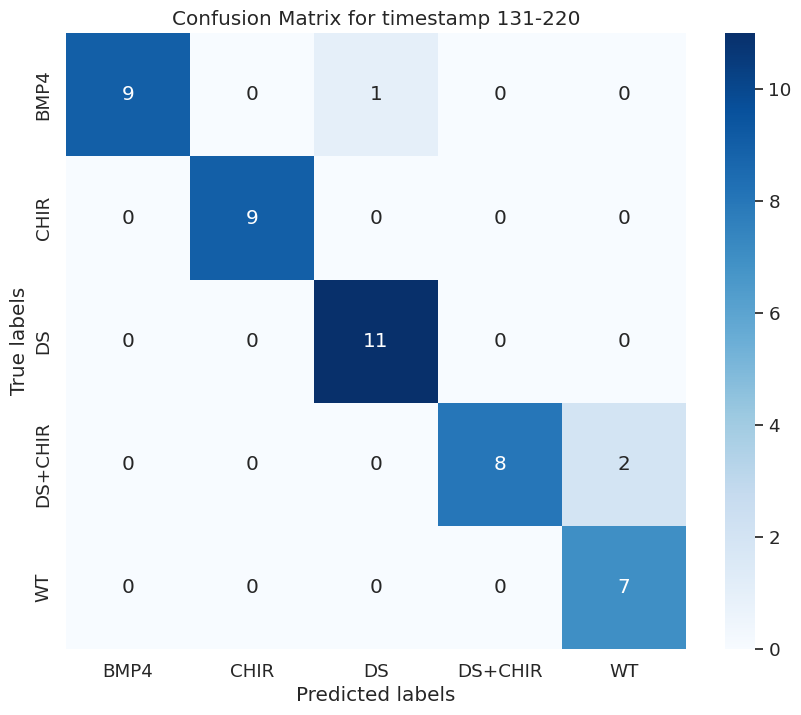

Trained and saved model for time range 131-220
loss for 131-220: 0.03565562143921852
accuracy for 131-220: 93.61702127659575


<Figure size 640x480 with 0 Axes>

In [5]:
print("starting")
metrics_map = {}
epochs = 200
batch_size = 8
for start_time in [131]:
    end_time = 220
# for start_time in range(100, 1, 50):
#     end_time = min(start_time+5, 289)
    seq_length = end_time-start_time+1
    print(f"Training for time range {start_time}-{end_time}")

    # Generate data loaders for the current time range
    train_loader, val_loader, test_loader = data_generator(batch_size, test_ratio=0.3, start_time=start_time, end_time=end_time)

    # Create a directory to save models for the current time range
    current_date = datetime.now().strftime('%Y-%m-%d')
    save_dir = os.path.join("saved_models/vivit/more", current_date)
    current_save_dir = os.path.join(save_dir, f"time_{start_time}_{end_time}")
    os.makedirs(current_save_dir, exist_ok=True)

    # Get the original model and optimizer
    model, criterion, optimizer = get_original_model(seq_length, batch_size)
    
    # Train and validate the model
    trained_model = train_and_validate(model, criterion, optimizer, epochs, train_loader, val_loader)
    # Test the trained model
    loss, acc, confusion = test(trained_model, criterion, test_loader)
    metrics = {"loss": loss, "accuracy": acc}
    for metric, value in metrics.items():
        if not f"{start_time}-{end_time}" in metrics_map:
            metrics_map[f"{start_time}-{end_time}"] = {}
        metrics_map[f"{start_time}-{end_time}"][metric] = value
    # Save the trained model
    model_name = "vivit_{}-{}_acc_{}_test_0_3".format(start_time, end_time, acc)
    model_filename = os.path.join(current_save_dir, f"{model_name}.pt")
    torch.save(trained_model.state_dict(), model_filename)

    os.makedirs(f"./output/vivit/more/{current_date}", exist_ok=True)
    plot_confusion_matrix(confusion, start_time, end_time, save=True, show=True,output=f"./output/vivit/more/{current_date}")


    # Print progress
    print(f"Trained and saved model for time range {start_time}-{end_time}")
for from_to_time, metrics in metrics_map.items():
    for metric, num in metrics.items():
        print(f"{metric} for {from_to_time }: {num}")

Training for time range 131-220
Epoch: 1 Validation: Average Loss: 0.2076, Accuracy: 23.40%
Epoch: 6 Validation: Average Loss: 0.2027, Accuracy: 31.91%
Epoch: 11 Validation: Average Loss: 0.1990, Accuracy: 44.68%
Epoch: 16 Validation: Average Loss: 0.1775, Accuracy: 46.81%
Epoch: 21 Validation: Average Loss: 0.1362, Accuracy: 61.70%
Epoch: 26 Validation: Average Loss: 0.1258, Accuracy: 63.83%
Epoch: 31 Validation: Average Loss: 0.1186, Accuracy: 78.72%
Epoch: 36 Validation: Average Loss: 0.1056, Accuracy: 87.23%
Epoch: 41 Validation: Average Loss: 0.1027, Accuracy: 87.23%
Epoch: 46 Validation: Average Loss: 0.1004, Accuracy: 89.36%
Epoch: 51 Validation: Average Loss: 0.0986, Accuracy: 89.36%
Epoch: 56 Validation: Average Loss: 0.0934, Accuracy: 89.36%
Epoch: 61 Validation: Average Loss: 0.0864, Accuracy: 89.36%
Epoch: 66 Validation: Average Loss: 0.0845, Accuracy: 89.36%
Epoch: 71 Validation: Average Loss: 0.0821, Accuracy: 91.49%
Epoch: 76 Validation: Average Loss: 0.0831, Accuracy: 9

<Figure size 640x480 with 0 Axes>

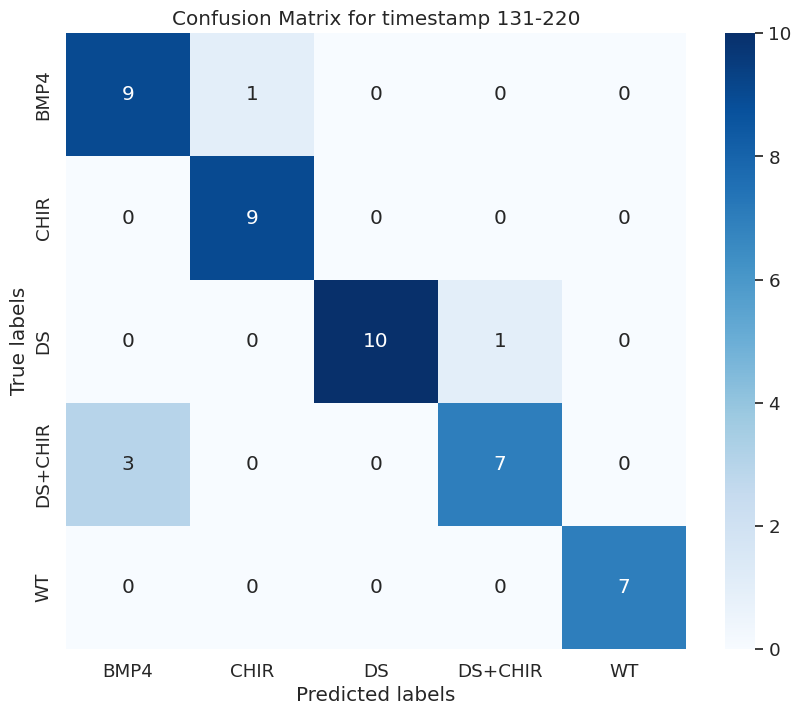

Trained and saved model for time range 131-220


<Figure size 640x480 with 0 Axes>

In [7]:
seq_length = end_time-start_time+1
print(f"Training for time range {start_time}-{end_time}")

# Generate data loaders for the current time range
# train_loader, val_loader, test_loader = data_generator(batch_size, test_ratio=0.3, start_time=start_time, end_time=end_time)

# Create a directory to save models for the current time range
current_date = datetime.now().strftime('%Y-%m-%d')
save_dir = os.path.join("saved_models/vivit/more", current_date)
current_save_dir = os.path.join(save_dir, f"time_{start_time}_{end_time}")
os.makedirs(current_save_dir, exist_ok=True)

# Get the original model and optimizer
model, criterion, optimizer = get_original_model(seq_length, batch_size)

# Train and validate the model
trained_model = train_and_validate(model, criterion, optimizer, epochs, train_loader, val_loader)
# Test the trained model
loss, acc, confusion = test(trained_model, criterion, test_loader)
metrics = {"loss": loss, "accuracy": acc}
for metric, value in metrics.items():
    if not f"{start_time}-{end_time}" in metrics_map:
        metrics_map[f"{start_time}-{end_time}"] = {}
    metrics_map[f"{start_time}-{end_time}"][metric] = value
# Save the trained model
model_name = "vivit_{}-{}_acc_{}_test_0_3".format(start_time, end_time, acc)
model_filename = os.path.join(current_save_dir, f"{model_name}.pt")
torch.save(trained_model.state_dict(), model_filename)

os.makedirs(f"./output/vivit/more/{current_date}", exist_ok=True)
plot_confusion_matrix(confusion, start_time, end_time, save=True, show=True,output=f"./output/vivit/more/{current_date}")


# Print progress
print(f"Trained and saved model for time range {start_time}-{end_time}")